# Gap Analysis Step 3: Estimate Electrical Losses Using SCADA and Revenue Meter Data

In [1]:
%load_ext autoreload
%autoreload 2

Calculating electrical losses in this method is relatively straightforward. In short, the sum of turbine energy is compared to the sum of metered energy, with the differnce equaling the electrical losses for the wind farm. However, the time resolution of the metered data and dealing with missing data are important aspects of this method.

The approach is to first calculate daily sums of turbine and revenue meter energy over the 
plant period of record. Only those days where all turbines and the revenue meter were 
reporting for all timesteps are considered. Electrical loss is then the difference in 
total turbine energy production and meter production over those concurrent days. 
    
Uncertainty in the calculated electrical losses is estimated by applying a Monte Carlo approach to sample revenue meter data and SCADA data with a 0.5% imposed uncertainty. One filtering parameter is sampled too.
The uncertainty in estimated electrical losses is quantified as the standard deviation
of the distribution of losses obtained from the MC sampling.
    
In this example, the procedure for calculating electrical losses is illustrated with and without uncertainty quantification.
    
In the case that meter data is not provided on a daily or sub-daily basis (e.g. monthly), a
different approach is implemented. The sum of daily turbine energy is corrected for any missing 
reported energy data from the turbines based on the ratio of expected number of data counts per day 
to the actual. Daily corrected sum of turbine energy is then summed on a monthly basis. Electrical 
loss is then the difference between total corrected turbine energy production and meter production 
over those concurrent months.   

In [1]:
# Import required packages
from datetime import datetime

import numpy as np
import pandas as pd

from openoa.analysis import ElectricalLosses

from openoa import PlantData

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [2]:
# Load wind farm object, append the analysis type for this example, and revalidate the data
project = PlantData.from_entr("La Haute Borne", schema="ElectricalLosses")

{'scada': {'columns': ['id', 'WMET_HorWdSpd', 'WTUR_W'], 'freq': ('D', 'H', 'T', 'min', 'S', 'L', 'ms', 'U', 'us', 'N')}, 'meter': {'columns': ['MMTR_SupWh'], 'freq': ('M', 'MS', 'W', 'D', 'H', 'T', 'min', 'S', 'L', 'ms', 'U', 'us', 'N')}}
scada
'WMET.HorWdSpd','WTUR.W'
SELECT interval_s, value_type, value_units FROM openoa_wtg_scada_tag_metadata WHERE entr_tag_name in ('WMET.HorWdSpd','WTUR.W');
   interval_s value_type value_units
0  600.000000    average         m/s
1  600.000000    average           W
SELECT float(`WMET.HorWdSpd`) as WMET_HorWdSpd ,float(`WTUR.W`) as WTUR_W , date_time as time,entr_warehouse.openoa_wtg_scada.wind_turbine_name as WTUR_TurNam FROM openoa_wtg_scada WHERE plant_id = 1 ORDER BY time;
meter
'MMTR.SupWh'
SELECT interval_s, value_type, value_units FROM openoa_revenue_meter_tag_metadata WHERE entr_tag_name in ('MMTR.SupWh');
   interval_s value_type value_units
0  600.000000        sum         kWh
SELECT float(`MMTR.SupWh`) as MMTR_SupWh , date_time as time

INFO:numexpr.utils:NumExpr defaulting to 5 threads.


METADATA:
{'latitude': Decimal('48.452000'), 'longitude': Decimal('5.588000'), 'capacity': Decimal('8.200000'), 'number_of_turbines': 4, 'turbine_capacity': Decimal('2.050000'), '_entr_plant_id': 1, 'scada': {'frequency': Timedelta('0 days 00:10:00'), 'time': 'time', 'WMET_HorWdSpd': 'WMET_HorWdSpd', 'WTUR_W': 'WTUR_W'}, 'meter': {'frequency': Timedelta('0 days 00:10:00'), 'time': 'time', 'MMTR_SupWh': 'MMTR_SupWh'}}
TABLES:
{'scada':         WMET_HorWdSpd         WTUR_W                time WTUR_TurNam
0                6.39  441060.000000 2014-01-01 00:00:00      R80721
1                6.87  514240.000000 2014-01-01 00:00:00      R80711
2                7.12  642780.000000 2014-01-01 00:00:00      R80736
3                7.11  658530.000000 2014-01-01 00:00:00      R80790
4                7.01  640240.000000 2014-01-01 00:10:00      R80790
...               ...            ...                 ...         ...
420427           5.04  203539.984375 2015-12-31 23:40:00      R80790
420428   

In [3]:
#project.validate()

## Electrical loss estimation without uncertainty quantification

Next we create an Electrical Loss object which will contain the analysis to be performed. The method has the ability to calculate uncertainty in the electrical losses through a Monte Carlo sampling of power data based on its measurement uncertainty. For now, we turn this option off and calculate a single electrical loss value.

In [4]:
# Create Electrical Loss object
el = ElectricalLosses(
    project,
    UQ=False,  # (default), only run a single simulation
    uncertainty_correction_threshold=0.95,  # (default) exclude months with < 95% coverage
)

INFO:openoa.analysis.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.analysis.electrical_losses:Note: uncertainty quantification will NOT be performed in the calculation
INFO:openoa.analysis.electrical_losses:Processing SCADA data
INFO:openoa.analysis.electrical_losses:Processing meter data


In [5]:
# Now we run the analysis using the run() function in the method
el.run()

INFO:openoa.analysis.electrical_losses:Calculating electrical losses
100%|██████████| 1/1 [00:00<00:00, 141.84it/s]


Now that the analyiss is complete, let's examine the results

In [6]:
el.electrical_losses[0][0]

0.020008333235557174

In [7]:
# Electrical losses for the wind farm
print(f"Electrical losses are {el.electrical_losses[0][0]:.1%}")

Electrical losses are 2.0%


Now let's plot electrical losses by month

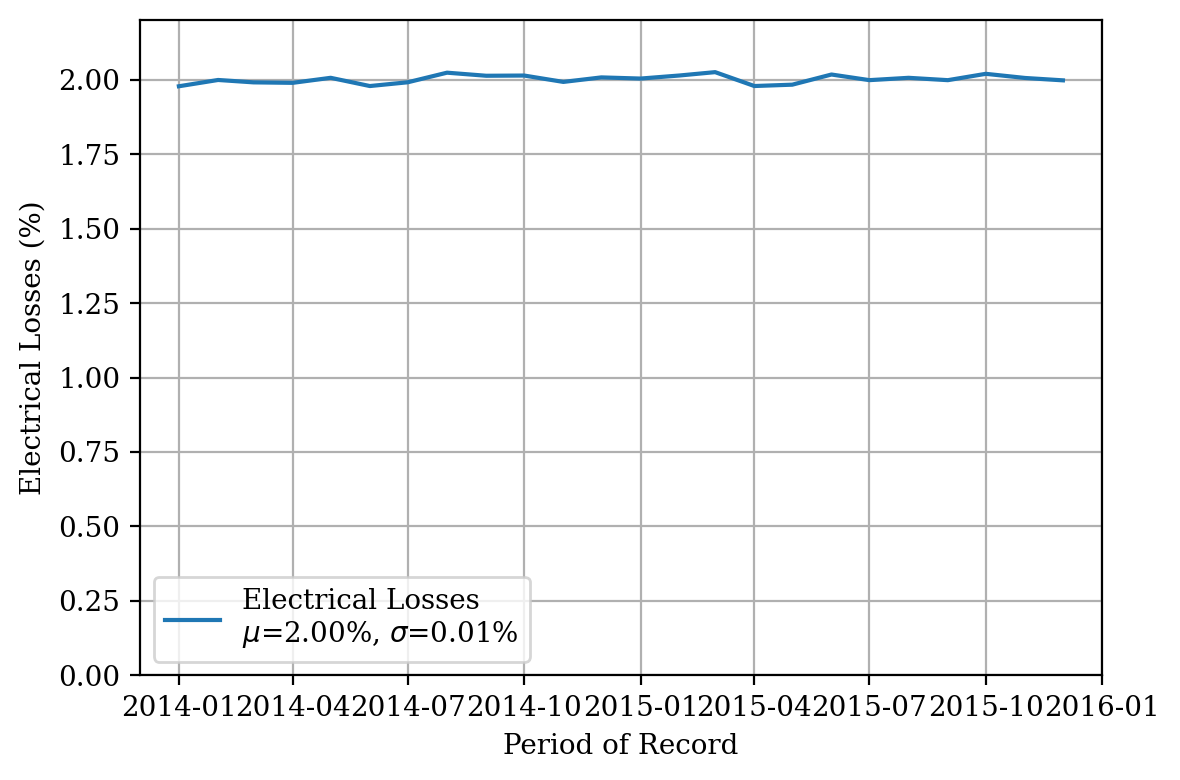

In [8]:
el.plot_monthly_losses(
    xlim=(datetime(month=12, day=1, year=2013), datetime(month=1, day=1, year=2016)),
    ylim=(0, 2.2)
)

We see that electrical losses vary between 1.98 and 2.02%. This is a narrow range, but keep in mind the meter data for La Haute Borne was synthesized by NREL based on the SCADA data and sampling around a 2% electrical loss with a standard deviation of 0.5%. Part of the reason for the very low spread in estimated monthly electrical losses is that uncertainty was introduced to the meter data at the 10-minute level when the data were synthesized. This uncertainty tends to get averaged out over the period of record. Normally electrical losses using actual meter data would not be this consistent and would generally show seasonal trends.

## Electrical loss estimation including uncertainty quantification

Next we create an Electrical Loss object with uncertainty quantification enabled and the number of Monte Carlo simulations set to 3000. This method calculates uncertainty in the electrical losses through a Monte Carlo sampling of power data based on its assumed measurement uncertainty of 0.5%. Furthermore, if dealing with monthly meter data, a range of availabiity thresholds used to remove months with low data coverage is sampled. 

In [9]:
# Create Electrical Loss object
el = ElectricalLosses(
    project, UQ = True, # enable UQ
    num_sim = 3000, # number of Monte Carlo simulations to perform
    uncertainty_meter=0.005, # 0.5% uncertainty in meter data
    uncertainty_scada=0.005,  # 0.5% uncertainty in scada data
    uncertainty_correction_threshold=(0.9, 0.995), # randomly sample between 90% and 99.5% coverage required in a month
)

INFO:openoa.analysis.electrical_losses:Initializing Electrical Losses Object
INFO:openoa.analysis.electrical_losses:Note: uncertainty quantification will be performed in the calculation
INFO:openoa.analysis.electrical_losses:Processing SCADA data
INFO:openoa.analysis.electrical_losses:Processing meter data


In [10]:
# Now we run the analysis using the run() function in the method
el.run()

INFO:openoa.analysis.electrical_losses:Calculating electrical losses
100%|██████████| 3000/3000 [00:05<00:00, 591.03it/s]


Now let's examine the results from the Monte Carlo simulations

In [11]:
# Electrical losses for the wind farm
print(f"Electrical losses are {el.electrical_losses.mean():.2%}")
print(f"Uncertainty in the electrical loss estimate is {el.electrical_losses.std():.2%}")

Electrical losses are 1.98%
Uncertainty in the electrical loss estimate is 0.69%


Again, the expected electrical losses are 2.0 percent. The uncertainty in the calculated losses is estimated to be 0.7%. This uncertainty value is given by the standard deviation of electrical losses over all Monte Carlo iterations and is primarily driven by the assumed 0.5% uncertainty for meter and SCADA power values. 